In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from  pandas_datareader import data as  web
import datetime as dt
from matplotlib import style
from numpy.linalg import inv

In [30]:
def list_idx30_tickers():
    df_companies=pd.read_html('https://market.bisnis.com/read/20200930/192/1298715/9-bulan-kapitalisasi-pasar-10-big-caps-susut-rp87118-triliun')
    tickers=df_companies[3]+str('.JK')
    tickers= tickers.loc[:,3].iloc[1:].iloc[:5]
    return tickers


list_idx30_tickers()
idx30= list_idx30_tickers().tolist()


In [31]:
startdate='2010-09-30'
enddate='2020-09-30'

In [32]:
df=pd.DataFrame()
for i in idx30:
    df[i]=web.DataReader(i, data_source='yahoo', start=startdate, end=enddate)['Adj Close']
    
    
df.head()

,BBCA.JK,BBRI.JK,UNVR.JK,TLKM.JK,BMRI.JK
2010-09-30,5819.299316,360.612488,1423.558228,777.362488,2311.602051
2010-10-01,6079.863281,362.415466,1444.679443,794.261597,2199.231445
2010-10-04,5949.582031,373.233887,1474.249023,806.936035,2247.391357
2010-10-05,5906.154297,382.249176,1465.800415,828.059998,2231.339600
2010-10-06,5993.009277,382.249176,1470.024536,802.711243,2247.391357


In [33]:
returns = np.log(df/df.shift(1))
cov_mat= returns.cov()*252
cov_mat

,BBCA.JK,BBRI.JK,UNVR.JK,TLKM.JK,BMRI.JK
BBCA.JK,0.066380,0.050135,0.031225,0.031031,0.049429
BBRI.JK,0.050135,0.128869,0.037338,0.043964,0.083035
UNVR.JK,0.031225,0.037338,0.097871,0.030157,0.038145
TLKM.JK,0.031031,0.043964,0.030157,0.094295,0.041549
BMRI.JK,0.049429,0.083035,0.038145,0.041549,0.118137


In [34]:
Sigma = np.array([[0.066426, 0.050217, 0.031185,0.031210,0.049536],[0.050217, 0.128962, 0.037284,0.044219, 0.083181],
                   [0.031185, 0.037284, 0.097842, 0.030073, 0.038082], [0.031210,0.044219, 0.030073,0.094769, 0.041870 ],
                  [0.049536,0.083181,0.038082,0.041870, 0.118312 ]])

delta = 2.5
tau = 0.05
w = np.array([[0.366, 0.202, 0.164, 0.14, 0.128]]).T# based on market cap
P = np.array([[1,0,-1,0,0],
              [0,-0.75, 0, -0.25,1]])
Q = np.array([[0.05], [0.03]])

In [59]:
def implied_return(delta,Sigma, w):
    ir = delta*Sigma.dot(w)
    return ir


def confidence_matrix(P,tau,Sigma):
    con_mat =  np.diag(P.dot(tau*Sigma).dot(P.T))
    return con_mat


def bl ( delta, tau, Sigma, P, Q):
    omega = confidence_matrix(P,tau,Sigma) 
    pi = implied_return(delta,Sigma,w)
    posterior_r = pi + np.dot( np.dot( tau*np.dot(Sigma,P.T), np.linalg.inv(tau*np.dot(np.dot(P,Sigma),P.T)+omega)), 
                              (Q-np.dot(P,pi)))
    
    posterior_s = Sigma +tau*Sigma-tau*np.dot( np.dot( np.dot(Sigma,P.T), np.linalg.inv(tau*np.dot(np.dot(P,Sigma),P.T)+omega)),
                                                 tau*np.dot(P,Sigma))
    
    posterior_w = np.dot(np.linalg.inv(delta*posterior_s), posterior_r)
    
    return (posterior_r, posterior_s,posterior_w)

In [60]:
r_posterior, s_posterior_s, weight_new = bl ( delta, tau, Sigma, P, Q)
r_posterior, s_posterior_s, weight_new

(array([[0.13081237],
        [0.16751171],
        [0.10163361],
        [0.1083162 ],
        [0.16189159]]),
 array([[0.06938833, 0.05249355, 0.03346372, 0.03269948, 0.05206964],
        [0.05241649, 0.1349187 , 0.03988603, 0.04620137, 0.08787686],
        [0.03349414, 0.03975144, 0.10118619, 0.03179093, 0.03967488],
        [0.03265483, 0.04618747, 0.03187441, 0.0993878 , 0.04426431],
        [0.05220001, 0.08794975, 0.03941841, 0.04428303, 0.12337324]]),
 array([[0.40212838],
        [0.16234489],
        [0.10263352],
        [0.12332131],
        [0.16195285]]))

In [63]:
df = pd.DataFrame([w.reshape(5),weight_new.reshape(5)],
                  columns=['BBCA.JK','BBRI.JK','UNVR.JK','TLKM.JK','BMRI.JK'],
                  index=['Initial Weights','Posterior Weights'])

In [64]:
df

,BBCA.JK,BBRI.JK,UNVR.JK,TLKM.JK,BMRI.JK
Initial Weights,0.366000,0.202000,0.164000,0.140000,0.128000
Posterior Weights,0.402128,0.162345,0.102634,0.123321,0.161953


<AxesSubplot:>

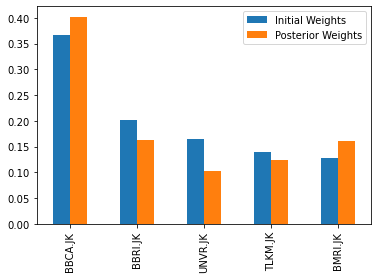

In [65]:
df.T.plot(kind='bar')